In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
x=pd.read_csv('all-states-history.csv',index_col='date',parse_dates=True,usecols=['date','state','positive'])

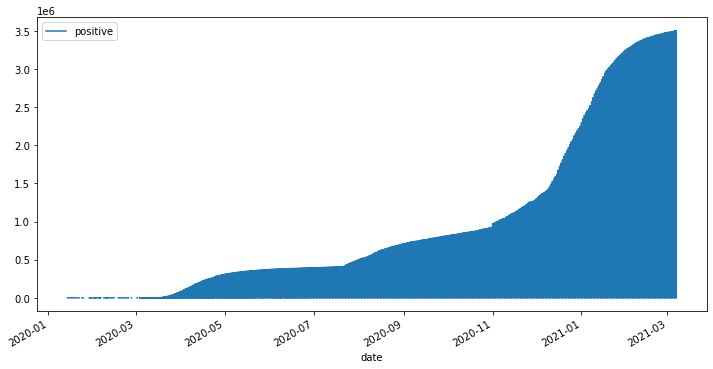

In [11]:
x.plot(figsize=(12,6))

In [12]:
az=x.query('state == "AZ"')
az=az.iloc[::-1]
az

,state,positive
date,,
2020-03-04,AZ,2.0
2020-03-05,AZ,2.0
2020-03-06,AZ,3.0
2020-03-07,AZ,5.0
2020-03-08,AZ,5.0
...,...,...
2021-03-03,AZ,819954.0
2021-03-04,AZ,821108.0
2021-03-05,AZ,823384.0


In [13]:
az.shape

(369, 2)

In [14]:
#az['rolling_sum']=az['positiveIncrease'].cumsum()

In [15]:
az=az[['positive']]

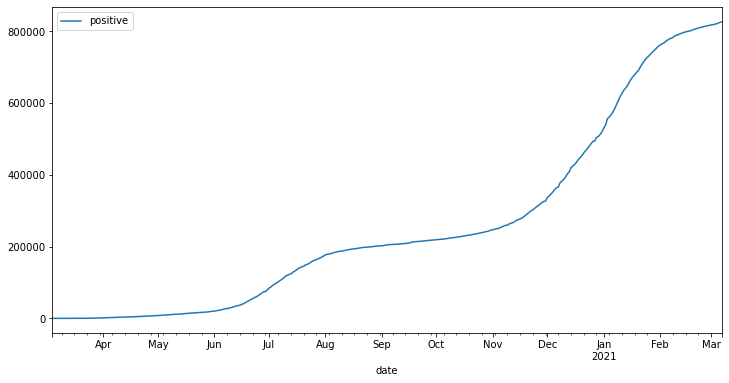

In [16]:
az.plot(figsize=(12,6))
plt.savefig('Positive.png')

In [17]:
#az=az[['rolling_sum']]
type(az)

pandas.core.frame.DataFrame

# March 2020 - August 2020

In [31]:
train=az.iloc[:151]
test=az.iloc[151:181]

In [32]:
type(train)

pandas.core.frame.DataFrame

In [33]:
#train=np.array(train).reshape(-1,1)
#test=np.array(test).reshape(-1,1)

In [34]:
len(test)

30

In [35]:
az.head(),az.tail()

(            positive
 date                
 2020-03-04       2.0
 2020-03-05       2.0
 2020-03-06       3.0
 2020-03-07       5.0
 2020-03-08       5.0,
             positive
 date                
 2021-03-03  819954.0
 2021-03-04  821108.0
 2021-03-05  823384.0
 2021-03-06  825119.0
 2021-03-07  826454.0)

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [37]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [38]:
#pip install tensorflow

In [39]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
n_inputs=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_inputs,batch_size=1)

In [41]:
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00000000e+00 5.64971751e-06 1.69491525e-05 1.69491525e-05
 1.69491525e-05 2.25988701e-05 3.95480226e-05 3.95480226e-05
 3.95480226e-05 5.64971751e-05 5.64971751e-05 9.03954802e-05]
Predict this y: 
 [[0.00010169]]


In [42]:
X.shape

(1, 12, 1)

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [44]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [46]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0247
Epoch 2/50
139/139 [==============================] - 1s 5ms/step - loss: 7.7572e-04
Epoch 3/50
139/139 [==============================] - 1s 4ms/step - loss: 3.2746e-04
Epoch 4/50
139/139 [==============================] - 1s 4ms/step - loss: 8.7467e-05
Epoch 5/50
139/139 [==============================] - 1s 4ms/step - loss: 9.7853e-05
Epoch 6/50
139/139 [==============================] - 1s 4ms/step - loss: 1.0090e-04
Epoch 7/50
139/139 [==============================] - 1s 4ms/step - loss: 4.4650e-05
Epoch 8/50
139/139 [==============================] - 1s 4ms/step - loss: 4.9887e-04
Epoch 9/50
139/139 [==============================] - 1s 4ms/step - loss: 2.5657e-04
Epoch 10/50
139/139 [==============================] - 1s 4ms/step - loss: 3.6934e-05
Epoch 11/50
139/139 [==============================] - 1s 4ms/step - loss: 1.2330e-04
Epoch 12/50
139/139 [==============================] - 1s 4ms/step 

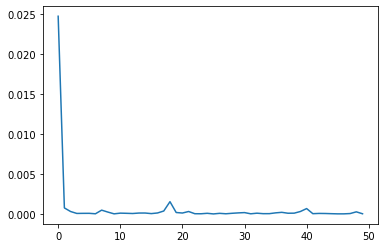

In [47]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [48]:
last_train_batch=scaled_train[-12:]

In [49]:
last_train_batch = last_train_batch.reshape((1, n_inputs, n_features))

In [50]:
model.predict(last_train_batch)

array([[1.0091826]], dtype=float32)

In [51]:
scaled_test[0]

array([1.00827684])

In [52]:
test_predictions = []

first_eval_batch = scaled_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
test_predictions

[array([1.0091826], dtype=float32),
 array([1.0217625], dtype=float32),
 array([1.0338978], dtype=float32),
 array([1.0454992], dtype=float32),
 array([1.0568955], dtype=float32),
 array([1.0678984], dtype=float32),
 array([1.0786113], dtype=float32),
 array([1.089074], dtype=float32),
 array([1.0992659], dtype=float32),
 array([1.1091799], dtype=float32),
 array([1.1187872], dtype=float32),
 array([1.1280301], dtype=float32),
 array([1.13693], dtype=float32),
 array([1.1455847], dtype=float32),
 array([1.1539565], dtype=float32),
 array([1.162056], dtype=float32),
 array([1.1698949], dtype=float32),
 array([1.177476], dtype=float32),
 array([1.1848034], dtype=float32),
 array([1.1918714], dtype=float32),
 array([1.1986973], dtype=float32),
 array([1.2052876], dtype=float32),
 array([1.2116474], dtype=float32),
 array([1.2177845], dtype=float32),
 array([1.2237059], dtype=float32),
 array([1.2294092], dtype=float32),
 array([1.2349082], dtype=float32),
 array([1.2402091], dtype=float32

In [54]:
true_predictions = scaler.inverse_transform(test_predictions)

In [55]:
true_predictions

array([[178627.31530857],
       [180853.96077824],
       [183001.90308285],
       [185055.35938931],
       [187072.50251961],
       [189020.01550388],
       [190916.1920805 ],
       [192768.10076427],
       [194572.07014751],
       [196326.83422756],
       [198027.3289938 ],
       [199663.32092476],
       [201238.60802841],
       [202770.49234104],
       [204252.30624866],
       [205685.90655518],
       [207073.403265  ],
       [208415.26057911],
       [209712.19589901],
       [210963.23862267],
       [212171.42715645],
       [213337.90090275],
       [214463.58826351],
       [215549.86074162],
       [216597.94213963],
       [217607.4315567 ],
       [218580.75549793],
       [219519.01116562],
       [220423.25356197],
       [221294.60098934]])

In [56]:
test['Predictions'] = true_predictions

<ipython-input-56-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [57]:
test.head()

,positive,Predictions
date,,
2020-08-02,178467.0,178627.315309
2020-08-03,179497.0,180853.960778
2020-08-04,180505.0,183001.903083
2020-08-05,182203.0,185055.359389
2020-08-06,183647.0,187072.502520


In [58]:
test.tail()

,positive,Predictions
date,,
2020-08-27,200139.0,217607.431557
2020-08-28,200658.0,218580.755498
2020-08-29,201287.0,219519.011166
2020-08-30,201661.0,220423.253562
2020-08-31,201835.0,221294.600989


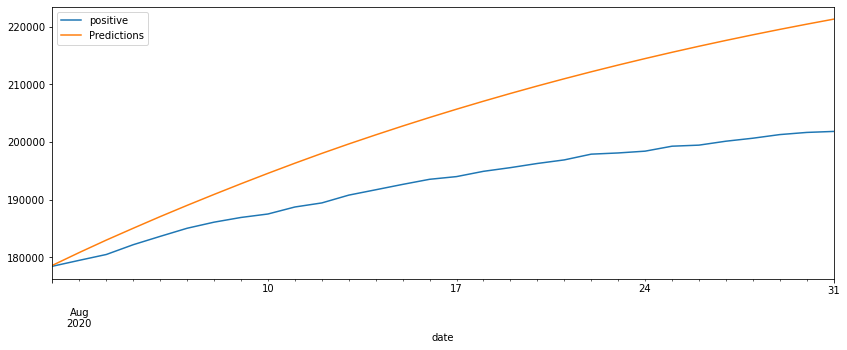

In [59]:
test.plot(figsize=(14,5))

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['positive'],test['Predictions']))
print(rmse)

12162.472887830732


### September 2020 - December 2020

In [61]:
train=az.iloc[181:241]
test=az.iloc[241:256]

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [63]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [64]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [65]:
n_inputs=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_inputs,batch_size=1)

In [66]:
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.01244515 0.03863031 0.05608709 0.07610963 0.0821044  0.08685226
 0.08879457 0.1006882  0.11174256 0.12423567 0.13874302 0.14795099]
Predict this y: 
 [[0.15305853]]


In [67]:
X.shape

(1, 12, 1)

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [69]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [71]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
48/48 [==============================] - 1s 5ms/step - loss: 0.0561
Epoch 2/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 3.6660e-04
Epoch 4/50
48/48 [==============================] - 0s 5ms/step - loss: 4.2070e-04
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 3.1902e-04
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 6.3025e-04
Epoch 7/50
48/48 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 8/50
48/48 [==============================] - 0s 6ms/step - loss: 3.0799e-04
Epoch 9/50
48/48 [==============================] - 0s 4ms/step - loss: 2.3854e-04
Epoch 10/50
48/48 [==============================] - 0s 4ms/step - loss: 2.6467e-04
Epoch 11/50
48/48 [==============================] - 0s 5ms/step - loss: 4.6570e-04
Epoch 12/50
48/48 [==============================] - 0s 4ms/step - loss: 2.1620e-04
Epoch 13/50
4

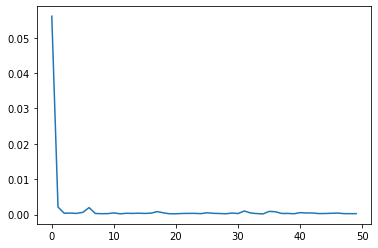

In [72]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [73]:
last_train_batch=scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_inputs, n_features))
model.predict(last_train_batch)

array([[1.0487106]], dtype=float32)

In [74]:
scaled_test[0]

array([1.04558425])

In [75]:
test_predictions = []

first_eval_batch = scaled_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



test_predictions

[array([1.0487106], dtype=float32),
 array([1.0874199], dtype=float32),
 array([1.1282389], dtype=float32),
 array([1.1717355], dtype=float32),
 array([1.2183478], dtype=float32),
 array([1.2685273], dtype=float32),
 array([1.3228606], dtype=float32),
 array([1.3813225], dtype=float32),
 array([1.4453986], dtype=float32),
 array([1.5154872], dtype=float32),
 array([1.5927417], dtype=float32),
 array([1.6779729], dtype=float32),
 array([1.7722448], dtype=float32),
 array([1.8767065], dtype=float32),
 array([1.9942746], dtype=float32)]

In [76]:
test.head()

,positive
date,
2020-10-31,245946.0
2020-11-01,247473.0
2020-11-02,248139.0
2020-11-03,249818.0
2020-11-04,250633.0


In [77]:
test.tail()

,positive
date,
2020-11-10,263133.0
2020-11-11,265163.0
2020-11-12,266562.0
2020-11-13,269577.0
2020-11-14,273053.0


In [78]:
true_predictions = scaler.inverse_transform(test_predictions)

In [79]:
true_predictions

array([[246076.37751126],
       [247690.670735  ],
       [249392.94753051],
       [251206.88660455],
       [253150.757797  ],
       [255243.39271426],
       [257509.25554192],
       [259947.29234636],
       [262619.45652747],
       [265542.36245394],
       [268764.10827565],
       [272318.50438201],
       [276249.92535555],
       [280606.29037631],
       [285509.23432112]])

In [80]:
test['Predictions'] = true_predictions

<ipython-input-80-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


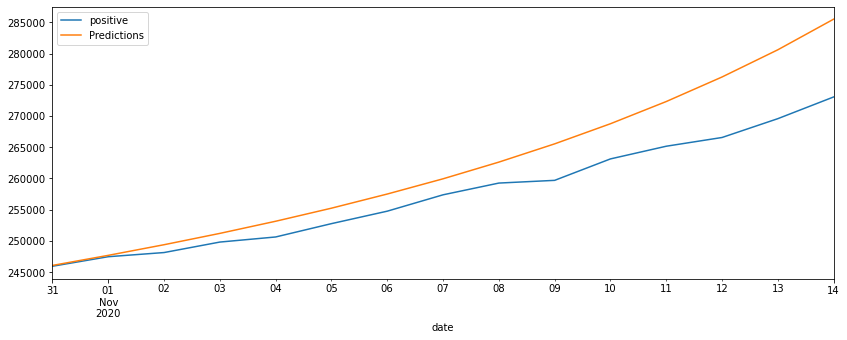

In [81]:
test.plot(figsize=(14,5))

In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['positive'],test['Predictions']))
print(rmse)

5939.207872674723


### Full Dataset - All months in dataset

In [83]:
train=az.iloc[:339]
test=az.iloc[339:]

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

from keras.preprocessing.sequence import TimeseriesGenerator
n_inputs=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_inputs,batch_size=1)

X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00000000e+00 1.28929115e-06 3.86787344e-06 3.86787344e-06
 3.86787344e-06 5.15716459e-06 9.02503803e-06 9.02503803e-06
 9.02503803e-06 1.28929115e-05 1.28929115e-05 2.06286584e-05]
Predict this y: 
 [[2.32072407e-05]]


In [85]:
X.shape

(1, 12, 1)

In [86]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
327/327 [==============================] - 2s 4ms/step - loss: 0.0057
Epoch 2/50
327/327 [==============================] - 1s 4ms/step - loss: 4.3307e-04
Epoch 3/50
327/327 [==============================] - 1s 4ms/step - loss: 4.1336e-04
Epoch 4/50
327/327 [==============================] - 1s 4ms/step - loss: 4.2768e-04
Epoch 5/50
327/327 [==============================] - 1s 4ms/step - loss: 2.3703e-04
Epoch 6/50
327/327 [==============================] - 1s 4ms/step - loss: 3.4119e-04
Epoch 7/50
327/327 [==============================] - 1s 4ms/step - loss: 1.6359e-04
Epoch 8/50
327/327 [==============================] - 1s 4ms/step - loss: 1.7450e-04
Epoch 9/50
327/327 [==============================] - 1s 4ms/step - loss: 2.0713e-04
Epoch 10/50
327/327 [==============================] - 1s 4ms/step - loss: 1.9946e-04
Epoch 11/50
327/327 [==============================] - 1s 4ms/step - loss: 3.8018e-04
Epoch 12/50
327/327 [==============================] - 1s 4ms/step 

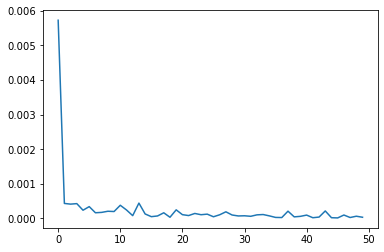

In [87]:
# fit model
model.fit(generator,epochs=50)
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.savefig('LSTM_loss.png')

In [88]:
last_train_batch=scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_inputs, n_features))
model.predict(last_train_batch)

array([[1.0054512]], dtype=float32)

In [89]:
scaled_test[0]

array([1.00447513])

In [90]:
test_predictions = []

first_eval_batch = scaled_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



test_predictions

[array([1.0054512], dtype=float32),
 array([1.0102427], dtype=float32),
 array([1.0150015], dtype=float32),
 array([1.0196698], dtype=float32),
 array([1.0241953], dtype=float32),
 array([1.0285907], dtype=float32),
 array([1.032853], dtype=float32),
 array([1.0369923], dtype=float32),
 array([1.0410044], dtype=float32),
 array([1.0448889], dtype=float32),
 array([1.048646], dtype=float32),
 array([1.0522816], dtype=float32),
 array([1.0557977], dtype=float32),
 array([1.0591979], dtype=float32),
 array([1.0624841], dtype=float32),
 array([1.0656602], dtype=float32),
 array([1.0687283], dtype=float32),
 array([1.0716906], dtype=float32),
 array([1.0745505], dtype=float32),
 array([1.0773113], dtype=float32),
 array([1.0799761], dtype=float32),
 array([1.0825486], dtype=float32),
 array([1.0850307], dtype=float32),
 array([1.0874248], dtype=float32),
 array([1.0897353], dtype=float32),
 array([1.091966], dtype=float32),
 array([1.0941185], dtype=float32),
 array([1.096195], dtype=float3

In [91]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

<ipython-input-91-df68ac2ffec1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [92]:
true_predictions

array([[779850.06159973],
       [783566.44342136],
       [787257.49089909],
       [790878.26793385],
       [794388.36902094],
       [797797.50257683],
       [801103.44953489],
       [804313.9766283 ],
       [807425.84771824],
       [810438.69296026],
       [813352.7897377 ],
       [816172.66864491],
       [818899.80905962],
       [821537.07727623],
       [824085.95267248],
       [826549.39400387],
       [828929.06557035],
       [831226.63167191],
       [833444.8661418 ],
       [835586.17296886],
       [837653.04860306],
       [839648.35933876],
       [841573.49209261],
       [843430.3885479 ],
       [845222.46976566],
       [846952.6945014 ],
       [848622.17228842],
       [850232.7523489 ],
       [851786.65374947],
       [853285.35586786]])

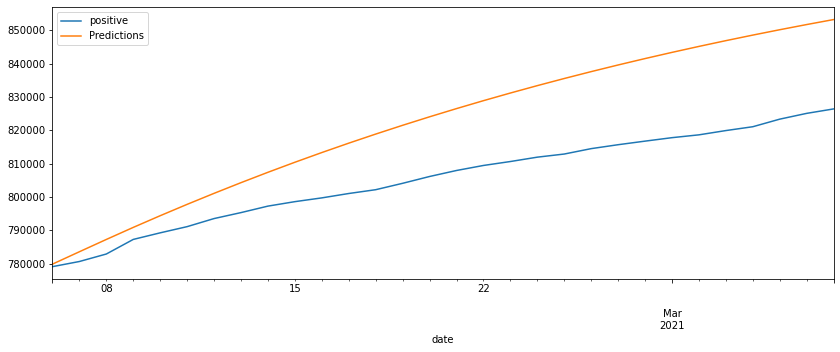

In [93]:
test.plot(figsize=(14,5))
plt.savefig('LSTM_pred.png')

In [94]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['positive'],test['Predictions']))
print(rmse)

18845.992886080447
